In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
from datetime import datetime
import lightgbm as lgb
from dotenv import load_dotenv
load_dotenv() 
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.config import TRANSFORMED_DATA_DIR
from src.data_utils import split_time_series_data
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow

In [2]:
def split_time_series_data_percentage(
    df: pd.DataFrame,
    target_column: str,
) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a time series DataFrame into training, validation, and testing sets (70%, 20%, 10%).

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        target_column (str): The name of the target column to separate from the features.

    Returns:
        Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
            - X_train (pd.DataFrame): Training features (70% of data).
            - y_train (pd.Series): Training target values.
            - X_val (pd.DataFrame): Validation features (20% of data).
            - y_val (pd.Series): Validation target values.
            - X_test (pd.DataFrame): Testing features (10% of data).
            - y_test (pd.Series): Testing target values.
    """
    # Sort the DataFrame by date
    df_sorted = df.sort_values("pickup_hour")

    # Calculate the split indices
    train_end = int(len(df) * 0.5)
    val_end = int(len(df) * 0.8)

    # Split the data into training, validation, and testing sets
    train_data = df_sorted[:train_end].reset_index(drop=True)
    val_data = df_sorted[train_end:val_end].reset_index(drop=True)
    test_data = df_sorted[val_end:].reset_index(drop=True)

    # Separate features (X) and target (y) for all three sets
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_val = val_data.drop(columns=[target_column])
    y_val = val_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")
df.head(5)
df.shape

(87620, 675)

In [4]:
X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data_percentage(df, target_column="target")

In [5]:
print(f"Train set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Train set shape: (43810, 674)
Validation set shape: (26286, 674)
Test set shape: (17524, 674)


In [6]:
def average_rides_last_4_weeks(X: pd.DataFrame) -> pd.DataFrame:
    last_4_weeks_columns = [
            f"rides_t-{7*24}",  # 1 week ago
            f"rides_t-{14*24}", # 2 weeks ago
            f"rides_t-{21*24}", # 3 weeks ago
            f"rides_t-{28*24}"  # 4 weeks ago
        ]

        # Ensure the required columns exist in the test DataFrame
    for col in last_4_weeks_columns:
        if col not in X.columns:
            raise ValueError(f"Missing required column: {col}")

    # Calculate the average of the last 4 weeks
    X["average_rides_last_4_weeks"] = X[last_4_weeks_columns].mean(axis=1)

    return X


add_feature_average_rides_last_4_weeks = FunctionTransformer(
    average_rides_last_4_weeks, validate=False
)


class TemporalFeatureEngineer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_["hour"] = X_["pickup_hour"].dt.hour
        X_["day_of_week"] = X_["pickup_hour"].dt.dayofweek

        return X_.drop(columns=["pickup_hour", "pickup_location_id"])

add_temporal_features = TemporalFeatureEngineer()

In [7]:
pipeline = make_pipeline(
    add_feature_average_rides_last_4_weeks,
    add_temporal_features,
    lgb.LGBMRegressor()
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124261 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157642
[LightGBM] [Info] Number of data points in the train set: 43810, number of used features: 674
[LightGBM] [Info] Start training from score 11.341954
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157642
[LightGBM] [Info] Number of data points in the train set: 43810, number of used features: 674
[LightGBM] [Info] Start training from score 11.341954
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 157642
[LightGBM] [Info] Number of data points in the train set: 43810, number of used features: 674
[LightGBM] [Info

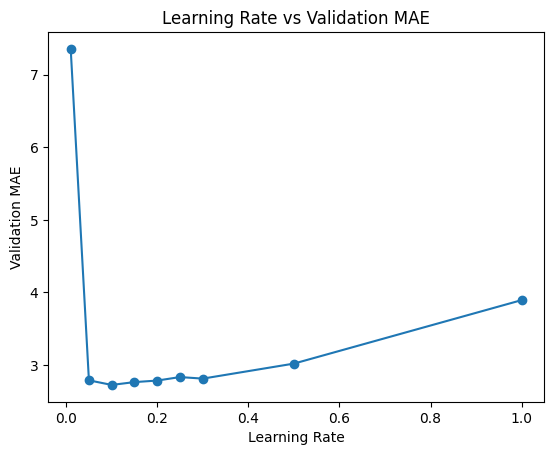

Best learning rate: 0.1


In [8]:
learning_rates = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.5, 1]
val_maes = []

for lr in learning_rates:
    model = pipeline.set_params(lgbmregressor__learning_rate=lr)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_maes.append(val_mae)

plt.plot(learning_rates, val_maes, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Validation MAE')
plt.title('Learning Rate vs Validation MAE')
plt.show()

best_lr = learning_rates[np.argmin(val_maes)]
print(f"Best learning rate: {best_lr}")

In [9]:
def plot_param_impact(param_name, param_range, X, y, pipeline, best_lr):
    maes = []
    for value in param_range:
        model = pipeline.set_params(
            lgbmregressor__learning_rate=best_lr,
            **{f"lgbmregressor__{param_name}": value}
        )
        scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
        maes.append(-scores.mean())
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_range, maes, marker='o')
    plt.xlabel(param_name)
    plt.ylabel('Validation MAE')
    plt.title(f'Impact of {param_name} on Validation MAE')
    plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154146
[LightGBM] [Info] Number of data points in the train set: 29206, number of used features: 674
[LightGBM] [Info] Start training from score 11.556084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.109052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154285
[LightGBM] [Info] Number of data points in the train set: 29207, number of used features: 674
[LightGBM] [Info] Start training from score 11.183586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153374
[LightGBM] [Info] Number of data points in the train set: 29207, number of used features: 674
[LightGBM] [Info

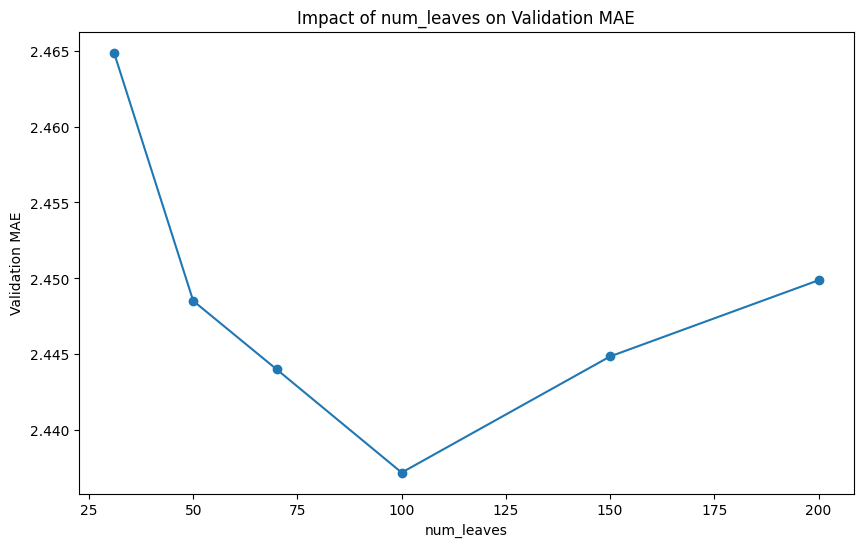

In [10]:
#Max Leaves
num_leaves_range = [31, 50, 70, 100, 150, 200]
plot_param_impact('num_leaves', num_leaves_range, X_train, y_train, pipeline, best_lr)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154146
[LightGBM] [Info] Number of data points in the train set: 29206, number of used features: 674
[LightGBM] [Info] Start training from score 11.556084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.087778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154285
[LightGBM] [Info] Number of data points in the train set: 29207, number of used features: 674
[LightGBM] [Info] Start training from score 11.183586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153374
[LightGBM] [Info] Number of data points in the train set: 29207, number of used features: 674
[LightGBM] [Info

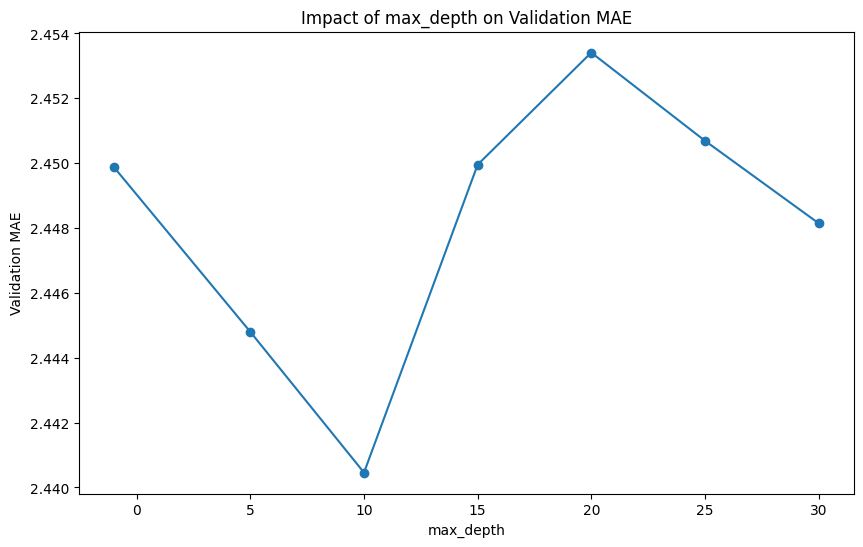

In [11]:
# Max Depth
max_depth_range = [-1, 5, 10, 15, 20, 25, 30]
plot_param_impact('max_depth', max_depth_range, X_train, y_train, pipeline, best_lr)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.117862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154146
[LightGBM] [Info] Number of data points in the train set: 29206, number of used features: 674
[LightGBM] [Info] Start training from score 11.556084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.089795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154285
[LightGBM] [Info] Number of data points in the train set: 29207, number of used features: 674
[LightGBM] [Info] Start training from score 11.183586
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 153374
[LightGBM] [Info] Number of data points in the train set: 29207, number of used features: 674
[LightGBM] [Info

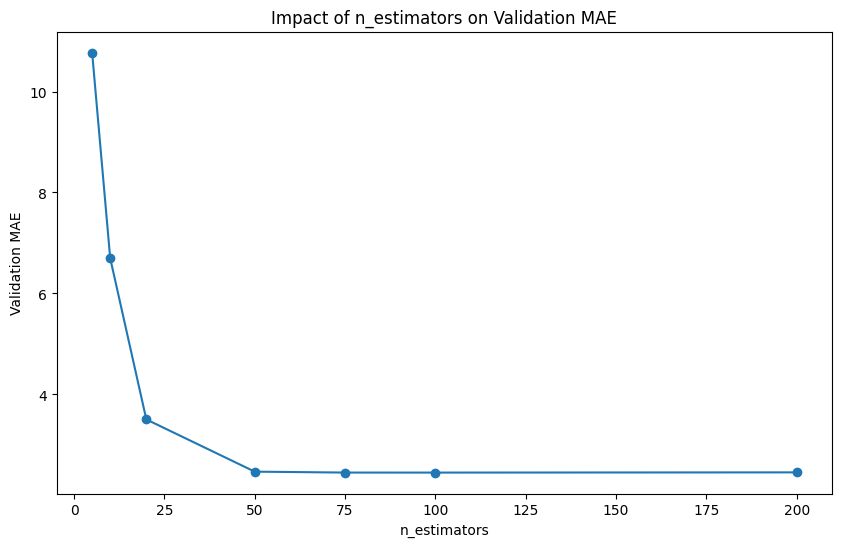

In [12]:
# N Estimators
n_estimators_range = [5, 10, 20, 50, 75, 100, 200]
plot_param_impact('n_estimators', n_estimators_range, X_train, y_train, pipeline, best_lr)

In [13]:
#Baseline Model parameters values we had used earlier for LightGBM
num_leaves = 50

param_distributions = {
    "lgbmregressor__num_leaves": [num_leaves - 10, num_leaves, num_leaves + 10],
}

random_search = RandomizedSearchCV(
    estimator=pipeline.set_params(lgbmregressor__learning_rate=best_lr),
    param_distributions=param_distributions,
    n_iter=5,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Validation Score (Negative MAE):", random_search.best_score_)

beaseline_model_lgbm = random_search.best_estimator_
y_pred = beaseline_model_lgbm.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Test Set MAE:", mae)

c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.105159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154146
[LightGBM] [Info] Number of data points in the train set: 29206, number of used features: 674
[LightGBM] [Info] Start training from score 11.556084
[CV] END .......................lgbmregressor__num_leaves=40; total time=   6.3s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.169109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154285
[LightGBM] [Info] Number of data points in the train set: 29207, number of used features: 674
[LightGBM] [Info] Start training from score 11.183586
[CV] END .......................lgbmregressor__num_leaves=40; total time=   6.1s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

In [14]:
#Using just best_num_leaves
best_num_leaves = 100

param_distributions = {
    "lgbmregressor__num_leaves": [best_num_leaves - 10, best_num_leaves, best_num_leaves + 10],
}

random_search = RandomizedSearchCV(
    estimator=pipeline.set_params(lgbmregressor__learning_rate=best_lr),
    param_distributions=param_distributions,
    n_iter=5,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Validation Score (Negative MAE):", random_search.best_score_)

lgbm_model_leaves = random_search.best_estimator_
y_pred = lgbm_model_leaves.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Test Set MAE:", mae)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\singh\Downloads\CDS500_Applied_ML_DS\Projects\CDA500P1\CDA500P1\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.090273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154146
[LightGBM] [Info] Number of data points in the train set: 29206, number of used features: 674
[LightGBM] [Info] Start training from score 11.556084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [15]:
best_num_leaves = 100
best_max_depth = 10

# Now use these best values in your RandomizedSearchCV
param_distributions = {
    "lgbmregressor__num_leaves": [best_num_leaves - 10, best_num_leaves, best_num_leaves + 10],
    "lgbmregressor__max_depth": [best_max_depth - 2, best_max_depth, best_max_depth + 2],
}

random_search = RandomizedSearchCV(
    estimator=pipeline.set_params(lgbmregressor__learning_rate=best_lr),
    param_distributions=param_distributions,
    n_iter=5,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Validation Score (Negative MAE):", random_search.best_score_)

lgbm_model_leave_depth = random_search.best_estimator_
y_pred = lgbm_model_leave_depth.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Test Set MAE:", mae)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154146
[LightGBM] [Info] Number of data points in the train set: 29206, number of used features: 674
[LightGBM] [Info] Start training from score 11.556084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [16]:
#Using all hyperparameters we had gotten from the graph
best_num_leaves = 100
best_max_depth = 10
best_n_estimators = 200

param_distributions = {
    "lgbmregressor__num_leaves": [best_num_leaves - 10, best_num_leaves, best_num_leaves + 10],
    "lgbmregressor__max_depth": [best_max_depth - 2, best_max_depth, best_max_depth + 2],
    "lgbmregressor__n_estimators": [best_n_estimators - 50, best_n_estimators, best_n_estimators + 50],
}

random_search = RandomizedSearchCV(
    estimator=pipeline.set_params(lgbmregressor__learning_rate=best_lr),
    param_distributions=param_distributions,
    n_iter=5,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Validation Score (Negative MAE):", random_search.best_score_)

lgbm_model_leave_depth_estimator = random_search.best_estimator_
y_pred = lgbm_model_leave_depth_estimator.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Test Set MAE:", mae)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154146
[LightGBM] [Info] Number of data points in the train set: 29206, number of used features: 674
[LightGBM] [Info] Start training from score 11.556084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
#using a few other recommended values for some of medium impace estimators
best_num_leaves = 100
best_max_depth = 10
best_n_estimators = 200

# Now use these best values in your RandomizedSearchCV
param_distributions = {
    "lgbmregressor__num_leaves": [best_num_leaves - 10, best_num_leaves, best_num_leaves + 10],
    "lgbmregressor__max_depth": [best_max_depth - 2, best_max_depth, best_max_depth + 2],
    "lgbmregressor__n_estimators": [best_n_estimators - 50, best_n_estimators, best_n_estimators + 50],
    "lgbmregressor__min_child_samples": [10, 20, 30, 50],
    "lgbmregressor__subsample": [0.6, 0.8, 1.0],
    "lgbmregressor__colsample_bytree": [0.6, 0.8, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=pipeline.set_params(lgbmregressor__learning_rate=best_lr),
    param_distributions=param_distributions,
    n_iter=5,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Validation Score (Negative MAE):", random_search.best_score_)

best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Test Set MAE:", mae)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.128058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154146
[LightGBM] [Info] Number of data points in the train set: 29206, number of used features: 674
[LightGBM] [Info] Start training from score 11.556084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [18]:
# After analyzing the graphs, choose the best values for each parameter
best_num_leaves = 70
best_max_depth = 20
best_n_estimators = 200

# Now use these best values in your RandomizedSearchCV
param_distributions = {
    "lgbmregressor__num_leaves": [best_num_leaves - 10, best_num_leaves, best_num_leaves + 10],
    "lgbmregressor__max_depth": [best_max_depth - 2, best_max_depth, best_max_depth + 2],
    "lgbmregressor__n_estimators": [best_n_estimators - 50, best_n_estimators, best_n_estimators + 50],
    "lgbmregressor__min_child_samples": [10, 20, 30, 50],
    "lgbmregressor__subsample": [0.6, 0.8, 1.0],
    "lgbmregressor__colsample_bytree": [0.6, 0.8, 1.0],
}

random_search = RandomizedSearchCV(
    estimator=pipeline.set_params(lgbmregressor__learning_rate=best_lr),
    param_distributions=param_distributions,
    n_iter=5,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Validation Score (Negative MAE):", random_search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 154146
[LightGBM] [Info] Number of data points in the train set: 29206, number of used features: 674
[LightGBM] [Info] Start training from score 11.556084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [19]:
best_model = random_search.best_estimator_
hyperparameters = best_model.get_params()
for param, value in hyperparameters.items():
    print(f"{param}: {value}")

memory: None
steps: [('functiontransformer', FunctionTransformer(func=<function average_rides_last_4_weeks at 0x0000022CFF2DFE20>)), ('temporalfeatureengineer', TemporalFeatureEngineer()), ('lgbmregressor', LGBMRegressor(colsample_bytree=0.6, max_depth=22, min_child_samples=30,
              n_estimators=150, num_leaves=60, subsample=0.6))]
transform_input: None
verbose: False
functiontransformer: FunctionTransformer(func=<function average_rides_last_4_weeks at 0x0000022CFF2DFE20>)
temporalfeatureengineer: TemporalFeatureEngineer()
lgbmregressor: LGBMRegressor(colsample_bytree=0.6, max_depth=22, min_child_samples=30,
              n_estimators=150, num_leaves=60, subsample=0.6)
functiontransformer__accept_sparse: False
functiontransformer__check_inverse: True
functiontransformer__feature_names_out: None
functiontransformer__func: <function average_rides_last_4_weeks at 0x0000022CFF2DFE20>
functiontransformer__inv_kw_args: None
functiontransformer__inverse_func: None
functiontransformer

In [20]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Test Set MAE:", mae)

Test Set MAE: 3.243189959542466


In [21]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")
df.head(5)

X_train, y_train, X_test, y_test = split_time_series_data(
    df,
    cutoff_date=datetime(2023, 9, 1, 0, 0, 0),
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(55900, 674)
(55900,)
(31720, 674)
(31720,)


In [22]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Test Set MAE:", mae)

Test Set MAE: 3.1952151129976873
